In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load the data
file_path = '/content/drive/My Drive/Thesis/Subject4.xlsx'
cgm_data = pd.read_excel(file_path, sheet_name='CGM')

In [3]:
# Preprocess - Round to nearest 5 minutes
cgm_data['date'] = pd.to_datetime(cgm_data['date']).dt.round('5min')

# Filter out rows where mg/dl is > 400 or missing values
cgm_data = cgm_data[cgm_data['mg/dl'] <= 400].dropna(subset=['mg/dl'])

# Drop duplicates and sort
cgm_data = cgm_data.drop_duplicates(subset='date').reset_index(drop=True)
cgm_data = cgm_data.sort_values(by='date').reset_index(drop=True)

In [4]:
# Generate AR Features (using past 12 readings as input)
num_lags = 12 # Using the past 12 values
for lag in range(1, num_lags + 1):
    cgm_data[f'lag_{lag}'] = cgm_data['mg/dl'].shift(lag)

cgm_data = cgm_data.dropna().reset_index(drop=True)

In [5]:
# Create labels for prediction (15, 30, 45, 60 mins into the future)
forecast_horizon = 3  # 15 minutes (3 readings ahead assuming 5-min intervals)
cgm_data['target'] = cgm_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to shifting
cgm_data = cgm_data.dropna().reset_index(drop=True)

# Split into features and labels
X = cgm_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
y = cgm_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Feed Forward Neural Network with Only Blood Glucose

In [6]:
# Build the neural network model
model = Sequential([
    Dense(64, activation='relu', input_dim=num_lags),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8958/8958 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 2527.9919 - mae: 32.3436 - val_loss: 326.8351 - val_mae: 12.7934
Epoch 2/5
8958/8958 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 643.7474 - mae: 19.0318 - val_loss: 300.5696 - val_mae: 12.1676
Epoch 3/5
8958/8958 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 593.1454 - mae: 18.1655 - val_loss: 280.9088 - val_mae: 11.7233
Epoch 4/5
8958/8958 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 548.4274 - mae: 17.4272 - val_loss: 271.1927 - val_mae: 11.5601
Epoch 5/5
8958/8958 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 527.9150 - mae: 17.0277 - val_loss: 283.8678 - val_mae: 11.8978
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 342.9119 - mae: 13.0741
Test Loss: 368.991455078125, Test MAE: 13.188017845153809
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [7]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 19.209154304937883


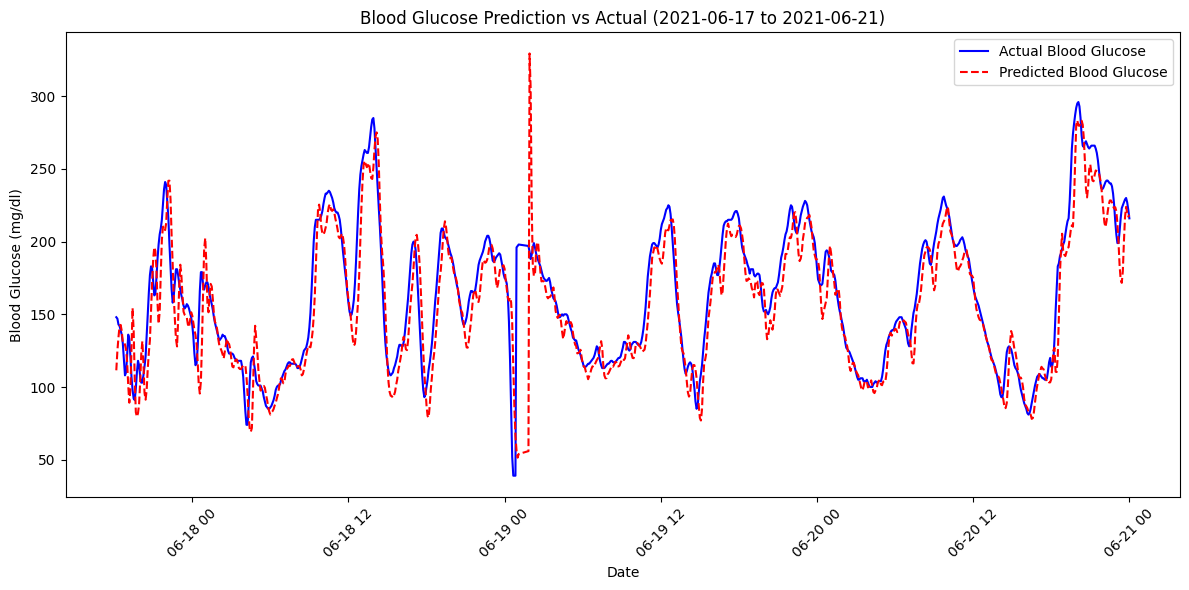

In [8]:
import matplotlib.pyplot as plt

# Add 'date' to the test data for plotting
test_dates = cgm_data['date'][train_size:].reset_index(drop=True)

# Function to plot actual vs predicted values for a specific week
def plot_predictions_for_week(test_dates, y_test, predictions, start_date, end_date):
    # Create a DataFrame for easier manipulation
    results = pd.DataFrame({
        'date': test_dates,
        'actual': y_test,
        'predicted': predictions.flatten()
    })

    # Filter data for the given date range
    week_data = results[(results['date'] >= start_date) & (results['date'] <= end_date)]

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(week_data['date'], week_data['actual'], label='Actual Blood Glucose', color='blue')
    plt.plot(week_data['date'], week_data['predicted'], label='Predicted Blood Glucose', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title(f'Blood Glucose Prediction vs Actual ({start_date} to {end_date})')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Specify the start and end date for the week
start_date = '2021-06-17'
end_date = '2021-06-21'

# Plot predictions for the specified week
plot_predictions_for_week(test_dates, y_test, predictions, start_date, end_date)


6

In [9]:
# Create labels for prediction (15, 30, 45, 60 mins into the future)
forecast_horizon = 6  # 15 minutes (3 readings ahead assuming 5-min intervals)
cgm_data['target'] = cgm_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to shifting
cgm_data = cgm_data.dropna().reset_index(drop=True)

# Split into features and labels
X = cgm_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
y = cgm_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [10]:
# Build the neural network model
model = Sequential([
    Dense(64, activation='relu', input_dim=num_lags),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8957/8957 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 3294.1846 - mae: 39.7080 - val_loss: 818.4064 - val_mae: 20.4412
Epoch 2/5
8957/8957 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 1217.5479 - mae: 26.5323 - val_loss: 726.1428 - val_mae: 19.3642
Epoch 3/5
8957/8957 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 1137.5271 - mae: 25.5375 - val_loss: 705.7671 - val_mae: 19.4803
Epoch 4/5
8957/8957 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 1086.9852 - mae: 24.9125 - val_loss: 683.7646 - val_mae: 18.7927
Epoch 5/5
8957/8957 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 1047.0321 - mae: 24.3737 - val_loss: 706.9023 - val_mae: 18.9170
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 845.2209 - mae: 20.6624
Test Loss: 841.1854248046875, Test MAE: 20.30598258972168
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [11]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 29.003176614412943


9

In [12]:
# Create labels for prediction (15, 30, 45, 60 mins into the future)
forecast_horizon = 9  # 15 minutes (3 readings ahead assuming 5-min intervals)
cgm_data['target'] = cgm_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to shifting
cgm_data = cgm_data.dropna().reset_index(drop=True)

# Split into features and labels
X = cgm_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
y = cgm_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [13]:
# Build the neural network model
model = Sequential([
    Dense(64, activation='relu', input_dim=num_lags),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8957/8957 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 3377.8342 - mae: 41.3879 - val_loss: 1191.4193 - val_mae: 25.5661
Epoch 2/5
8957/8957 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 1525.6984 - mae: 29.8854 - val_loss: 1174.2087 - val_mae: 24.7891
Epoch 3/5
8957/8957 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 1466.2260 - mae: 29.2286 - val_loss: 1123.2577 - val_mae: 24.7360
Epoch 4/5
8957/8957 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 1413.6235 - mae: 28.7062 - val_loss: 1118.0143 - val_mae: 24.3161
Epoch 5/5
8957/8957 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 1393.0997 - mae: 28.3801 - val_loss: 1127.7584 - val_mae: 24.2254
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1332.8307 - mae: 26.1581
Test Loss: 1298.3033447265625, Test MAE: 25.612977981567383
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [14]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 36.0319477036681


12

In [15]:
# Create labels for prediction (15, 30, 45, 60 mins into the future)
forecast_horizon = 12  # 15 minutes (3 readings ahead assuming 5-min intervals)
cgm_data['target'] = cgm_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to shifting
cgm_data = cgm_data.dropna().reset_index(drop=True)

# Split into features and labels
X = cgm_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
y = cgm_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [16]:
# Build the neural network model
model = Sequential([
    Dense(64, activation='relu', input_dim=num_lags),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8957/8957 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 3633.8223 - mae: 44.1416 - val_loss: 1574.2446 - val_mae: 29.2632
Epoch 2/5
8957/8957 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 1902.6829 - mae: 33.6869 - val_loss: 1550.3925 - val_mae: 28.8725
Epoch 3/5
8957/8957 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 1832.1880 - mae: 32.9813 - val_loss: 1495.7448 - val_mae: 28.6917
Epoch 4/5
8957/8957 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 1812.5043 - mae: 32.7646 - val_loss: 1489.5653 - val_mae: 28.6832
Epoch 5/5
8957/8957 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 1779.4351 - mae: 32.4404 - val_loss: 1494.9576 - val_mae: 28.5994
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1703.3330 - mae: 30.0679
Test Loss: 1657.107177734375, Test MAE: 29.516685485839844
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [17]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 40.7075786358002


Feed Forward Neural Network with Blood Glucose and Bolus

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error

# Load CGM and Bolus data
file_path = '/content/drive/My Drive/Thesis/Subject1.xlsx'
cgm_data = pd.read_excel(file_path, sheet_name='CGM')
bolus_data = pd.read_excel(file_path, sheet_name='Bolus')

In [19]:
# Preprocess CGM data
cgm_data['date'] = pd.to_datetime(cgm_data['date']).dt.round('5min')
cgm_data = cgm_data[cgm_data['mg/dl'] <= 400].dropna(subset=['mg/dl'])
cgm_data = cgm_data.drop_duplicates(subset='date').sort_values(by='date').reset_index(drop=True)

# Preprocess Bolus data
bolus_data['date'] = pd.to_datetime(bolus_data['date']).dt.round('5min')
bolus_data = bolus_data.fillna(0)  # Set missing values to 0

# Merge CGM and Bolus data
merged_data = pd.merge(cgm_data, bolus_data, on='date', how='left').fillna(0)

# Generate lag features for CGM (past glucose readings)
num_lags = 12  # Number of past readings to use
for lag in range(1, num_lags + 1):
    merged_data[f'lag_{lag}'] = merged_data['mg/dl'].shift(lag)

# Generate lag features for Bolus variables
bolus_vars = ['normal', 'carbInput', 'insulinCarbRatio', 'bgInput', 'recommended.carb',
              'recommended.net', 'recommended.correction', 'insulinSensitivityFactor',
              'targetBloodGlucose', 'insulinOnBoard']

for var in bolus_vars:
    for lag in range(1, num_lags + 1):
        merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)

<ipython-input-19-b23c5d981a10>:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-19-b23c5d981a10>:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-19-b23c5d981a10>:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

In [20]:
# Generate target variable (15-minute ahead glucose levels)
forecast_horizon = 3  # Predict 15 minutes ahead
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaNs introduced by lagging and shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features (X) and target (y)
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

<ipython-input-20-2e8ff43a49a4>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)


In [21]:
# Build the neural network model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Add a function to plot actual vs predicted
import matplotlib.pyplot as plt

test_dates = merged_data['date'][train_size:].reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 3309.1711 - mae: 36.8953 - val_loss: 536.2169 - val_mae: 16.5327
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 1042.0371 - mae: 23.8827 - val_loss: 418.7999 - val_mae: 13.8868
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 970.0607 - mae: 22.9196 - val_loss: 405.4397 - val_mae: 13.5887
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 941.4465 - mae: 22.4750 - val_loss: 411.1272 - val_mae: 13.6474
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 907.2344 - mae: 22.0080 - val_loss: 412.7660 - val_mae: 13.7959
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 366.2621 - mae: 13.2161
Test Loss: 369.5133972167969, Test MAE: 13.248205184936523
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Root Mean Squared Error (RMSE): 19.222739698945517


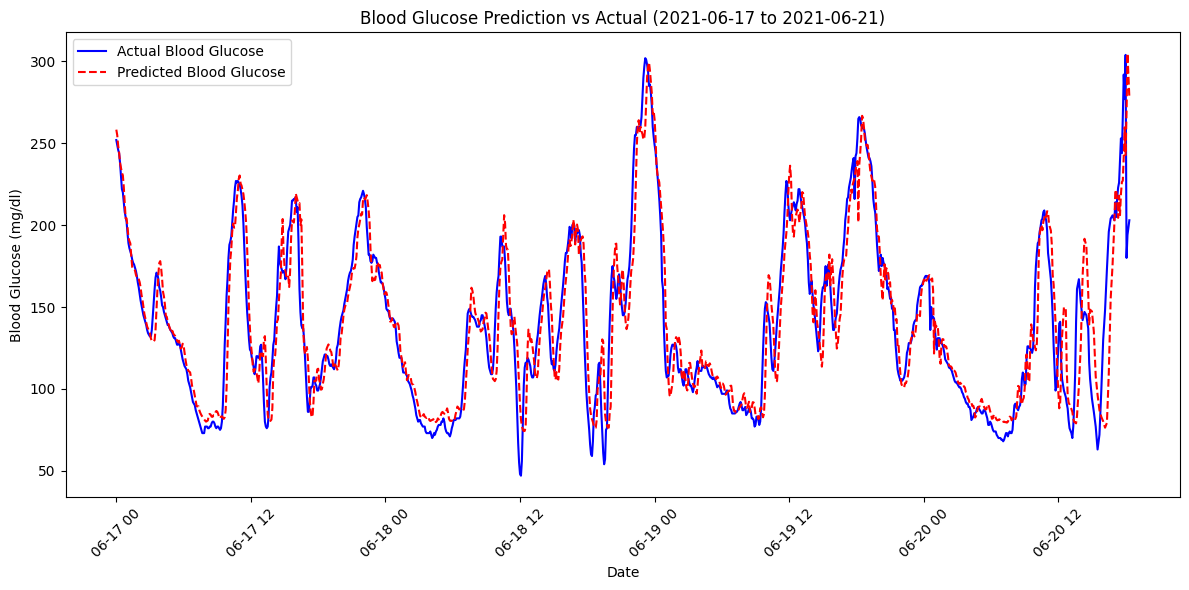

In [22]:
def plot_predictions_for_week(test_dates, y_test, predictions, start_date, end_date):
    results = pd.DataFrame({
        'date': test_dates,
        'actual': y_test,
        'predicted': predictions.flatten()
    })

    week_data = results[(results['date'] >= start_date) & (results['date'] <= end_date)]

    plt.figure(figsize=(12, 6))
    plt.plot(week_data['date'], week_data['actual'], label='Actual Blood Glucose', color='blue')
    plt.plot(week_data['date'], week_data['predicted'], label='Predicted Blood Glucose', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title(f'Blood Glucose Prediction vs Actual ({start_date} to {end_date})')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Specify dates for a week
start_date = '2021-06-17'
end_date = '2021-06-21'

# Plot predictions
plot_predictions_for_week(test_dates, y_test, predictions, start_date, end_date)

6

In [23]:
# Generate target variable (15-minute ahead glucose levels)
forecast_horizon = 6  # Predict 15 minutes ahead
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaNs introduced by lagging and shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features (X) and target (y)
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [24]:
# Build the neural network model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Add a function to plot actual vs predicted
import matplotlib.pyplot as plt

test_dates = merged_data['date'][train_size:].reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 3816.4329 - mae: 41.7292 - val_loss: 978.7224 - val_mae: 22.2683
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 1584.2520 - mae: 29.6659 - val_loss: 962.8875 - val_mae: 22.1639
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 1533.8534 - mae: 29.1459 - val_loss: 999.2559 - val_mae: 22.6057
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 1472.0475 - mae: 28.4401 - val_loss: 922.4671 - val_mae: 21.4924
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 1445.9313 - mae: 28.1182 - val_loss: 900.2452 - val_mae: 21.0210
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 825.0772 - mae: 20.3785
Test Loss: 843.2291870117188, Test MAE: 20.712472915649414
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Root Mean Squared Error (RMSE): 29.038407797860803


9

In [25]:
# Generate target variable (15-minute ahead glucose levels)
forecast_horizon = 9  # Predict 15 minutes ahead
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaNs introduced by lagging and shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features (X) and target (y)
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [26]:
# Build the neural network model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Add a function to plot actual vs predicted
import matplotlib.pyplot as plt

test_dates = merged_data['date'][train_size:].reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 4402.3242 - mae: 46.5486 - val_loss: 1652.7664 - val_mae: 29.9886
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 2109.0769 - mae: 34.7238 - val_loss: 1595.1572 - val_mae: 29.3320
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 2040.1602 - mae: 33.9430 - val_loss: 1568.3434 - val_mae: 29.0240
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 2006.9205 - mae: 33.5319 - val_loss: 1563.0090 - val_mae: 28.8882
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 1960.0267 - mae: 33.1416 - val_loss: 1453.4302 - val_mae: 27.8429
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 1343.7201 - mae: 27.0001
Test Loss: 1357.8406982421875, Test MAE: 27.27066421508789
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Root Mean Squared Error (RMSE): 36.84889010028219


12

In [27]:
# Generate target variable (15-minute ahead glucose levels)
forecast_horizon = 12  # Predict 15 minutes ahead
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaNs introduced by lagging and shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features (X) and target (y)
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [28]:
# Build the neural network model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Add a function to plot actual vs predicted
import matplotlib.pyplot as plt

test_dates = merged_data['date'][train_size:].reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 4881.3271 - mae: 50.4638 - val_loss: 2148.0637 - val_mae: 34.7800
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 2666.7410 - mae: 39.4550 - val_loss: 2063.7637 - val_mae: 34.0042
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 2600.8196 - mae: 38.8384 - val_loss: 2052.7930 - val_mae: 33.7418
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 2558.0679 - mae: 38.4401 - val_loss: 2080.5361 - val_mae: 33.9820
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 2514.8909 - mae: 38.0931 - val_loss: 2188.9001 - val_mae: 35.0966
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 1978.7521 - mae: 33.2511
Test Loss: 1873.679931640625, Test MAE: 32.214359283447266
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Root Mean Squared Error (RMSE): 43.28603080370683


LSTM with Blood Glucose and Bolus Data

In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load CGM and Bolus data (same preprocessing steps as before)
file_path = '/content/drive/My Drive/Thesis/Subject1.xlsx'
cgm_data = pd.read_excel(file_path, sheet_name='CGM')
bolus_data = pd.read_excel(file_path, sheet_name='Bolus')

# Preprocess CGM data
cgm_data['date'] = pd.to_datetime(cgm_data['date']).dt.round('5min')
cgm_data = cgm_data[cgm_data['mg/dl'] <= 400].dropna(subset=['mg/dl'])
cgm_data = cgm_data.drop_duplicates(subset='date').sort_values(by='date').reset_index(drop=True)

# Preprocess Bolus data
bolus_data['date'] = pd.to_datetime(bolus_data['date']).dt.round('5min')
bolus_data = bolus_data.fillna(0)

# Merge CGM and Bolus data
merged_data = pd.merge(cgm_data, bolus_data, on='date', how='left').fillna(0)

# Generate lag features for CGM and Bolus variables
num_lags = 12
for lag in range(1, num_lags + 1):
    merged_data[f'lag_{lag}'] = merged_data['mg/dl'].shift(lag)

bolus_vars = ['normal', 'carbInput', 'insulinCarbRatio', 'bgInput', 'recommended.carb',
              'recommended.net', 'recommended.correction', 'insulinSensitivityFactor',
              'targetBloodGlucose', 'insulinOnBoard']

for var in bolus_vars:
    for lag in range(1, num_lags + 1):
        merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)



<ipython-input-29-e2667385971b>:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-29-e2667385971b>:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-29-e2667385971b>:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

In [30]:
# Generate target variable
forecast_horizon = 3
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features and labels
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reshape input data for LSTM
X = X.reshape((X.shape[0], num_lags, int(X.shape[1] / num_lags)))

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

<ipython-input-30-4728be9a6491>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)


In [31]:
# Build LSTM model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 153s 17ms/step - loss: 18434.6875 - mae: 113.1944 - val_loss: 1709.7173 - val_mae: 27.4481
Epoch 2/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 206s 17ms/step - loss: 1172.9633 - mae: 23.8198 - val_loss: 464.3679 - val_mae: 15.1245
Epoch 3/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 196s 17ms/step - loss: 744.0598 - mae: 19.7448 - val_loss: 401.9434 - val_mae: 13.5001
Epoch 4/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 143s 16ms/step - loss: 705.8911 - mae: 19.2112 - val_loss: 406.6079 - val_mae: 13.6289
Epoch 5/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 145s 16ms/step - loss: 694.1707 - mae: 19.0052 - val_loss: 421.5727 - val_mae: 14.0856
Epoch 6/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 142s 16ms/step - loss: 682.9645 - mae: 18.8673 - val_loss: 382.7078 - val_mae: 13.2605
Epoch 7/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 148s 17ms/step - loss: 678.2606 - mae: 18.7296 - val_loss: 380.7650 - val_mae: 13.2827
Epoch 8/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 198s 16ms/step - loss: 666.3647 - mae: 18.5693 - v

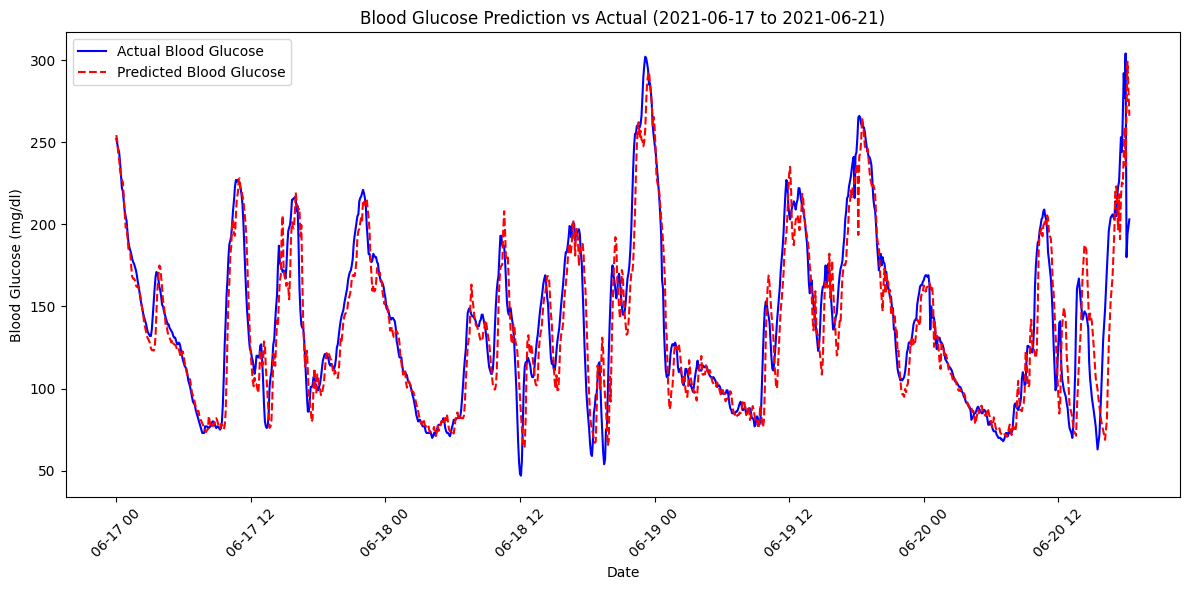

In [32]:
# Plot predictions vs actual for a given week
test_dates = merged_data['date'][train_size:].reset_index(drop=True)

def plot_predictions_for_week(test_dates, y_test, predictions, start_date, end_date):
    results = pd.DataFrame({
        'date': test_dates,
        'actual': y_test,
        'predicted': predictions.flatten()
    })

    week_data = results[(results['date'] >= start_date) & (results['date'] <= end_date)]

    plt.figure(figsize=(12, 6))
    plt.plot(week_data['date'], week_data['actual'], label='Actual Blood Glucose', color='blue')
    plt.plot(week_data['date'], week_data['predicted'], label='Predicted Blood Glucose', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title(f'Blood Glucose Prediction vs Actual ({start_date} to {end_date})')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Specify dates for a week
start_date = '2021-06-17'
end_date = '2021-06-21'

# Plot predictions
plot_predictions_for_week(test_dates, y_test, predictions, start_date, end_date)

6

In [33]:
# Generate target variable
forecast_horizon = 6
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features and labels
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reshape input data for LSTM
X = X.reshape((X.shape[0], num_lags, int(X.shape[1] / num_lags)))

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [34]:
# Build LSTM model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 148s 16ms/step - loss: 18681.5938 - mae: 114.3536 - val_loss: 2228.4998 - val_mae: 34.4496
Epoch 2/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 203s 16ms/step - loss: 1677.7330 - mae: 29.7520 - val_loss: 993.2999 - val_mae: 22.9508
Epoch 3/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 199s 16ms/step - loss: 1248.5717 - mae: 25.9566 - val_loss: 949.2723 - val_mae: 21.6484
Epoch 4/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 203s 16ms/step - loss: 1204.7435 - mae: 25.4760 - val_loss: 886.3438 - val_mae: 20.8795
Epoch 5/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 203s 16ms/step - loss: 1188.6481 - mae: 25.2416 - val_loss: 867.4590 - val_mae: 20.9674
Epoch 6/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 201s 16ms/step - loss: 1183.5677 - mae: 25.1476 - val_loss: 904.5294 - val_mae: 21.6712
Epoch 7/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 202s 16ms/step - loss: 1169.1477 - mae: 25.0341 - val_loss: 886.0251 - val_mae: 20.8384
Epoch 8/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 143s 16ms/step - loss: 1161.5070 - mae: 24.88

9

In [35]:
# Generate target variable
forecast_horizon = 9
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features and labels
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reshape input data for LSTM
X = X.reshape((X.shape[0], num_lags, int(X.shape[1] / num_lags)))

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [36]:
# Build LSTM model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 148s 16ms/step - loss: 18907.2012 - mae: 115.4019 - val_loss: 2644.2285 - val_mae: 38.1698
Epoch 2/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 201s 16ms/step - loss: 2153.6272 - mae: 34.6221 - val_loss: 1732.6948 - val_mae: 30.7708
Epoch 3/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 202s 16ms/step - loss: 1789.2922 - mae: 31.5868 - val_loss: 1477.0631 - val_mae: 27.6249
Epoch 4/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 201s 16ms/step - loss: 1763.5275 - mae: 31.2717 - val_loss: 1446.9755 - val_mae: 27.2401
Epoch 5/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 203s 16ms/step - loss: 1723.1692 - mae: 30.9237 - val_loss: 1421.6257 - val_mae: 27.0979
Epoch 6/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 202s 16ms/step - loss: 1703.5961 - mae: 30.6628 - val_loss: 1473.8810 - val_mae: 27.8715
Epoch 7/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 201s 16ms/step - loss: 1704.1375 - mae: 30.7092 - val_loss: 1406.2953 - val_mae: 27.2161
Epoch 8/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 202s 16ms/step - loss: 1682.2318 - mae:

12

In [37]:
# Generate target variable
forecast_horizon = 12
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features and labels
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reshape input data for LSTM
X = X.reshape((X.shape[0], num_lags, int(X.shape[1] / num_lags)))

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [38]:
# Build LSTM model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 150s 17ms/step - loss: 18397.0391 - mae: 113.6494 - val_loss: 3037.7864 - val_mae: 42.6890
Epoch 2/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 148s 17ms/step - loss: 2598.1824 - mae: 38.7540 - val_loss: 2127.1643 - val_mae: 35.2997
Epoch 3/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 149s 17ms/step - loss: 2283.3159 - mae: 36.1305 - val_loss: 2069.5588 - val_mae: 33.6414
Epoch 4/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 202s 17ms/step - loss: 2245.8774 - mae: 35.7802 - val_loss: 2015.8314 - val_mae: 33.3816
Epoch 5/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 199s 17ms/step - loss: 2236.8616 - mae: 35.7563 - val_loss: 2019.9214 - val_mae: 33.4334
Epoch 6/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 202s 17ms/step - loss: 2215.5017 - mae: 35.5430 - val_loss: 1954.4808 - val_mae: 32.6921
Epoch 7/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 146s 17ms/step - loss: 2194.0669 - mae: 35.3074 - val_loss: 1979.7144 - val_mae: 32.9071
Epoch 8/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 201s 16ms/step - loss: 2195.6902 - mae:

CNN

In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
import matplotlib.pyplot as plt

# Load CGM data
file_path = '/content/drive/My Drive/Thesis/Subject1.xlsx'
cgm_data = pd.read_excel(file_path, sheet_name='CGM')

# Preprocess CGM data - Round to nearest 5 minutes and filter
cgm_data['date'] = pd.to_datetime(cgm_data['date']).dt.round('5min')
cgm_data = cgm_data[cgm_data['mg/dl'] <= 400].dropna(subset=['mg/dl'])
cgm_data = cgm_data.drop_duplicates(subset='date').sort_values(by='date').reset_index(drop=True)

# Generate lag features for CGM data
num_lags = 12  # Using the past 12 readings as features
for lag in range(1, num_lags + 1):
    cgm_data[f'lag_{lag}'] = cgm_data['mg/dl'].shift(lag)

# Load Bolus data
bolus_data = pd.read_excel(file_path, sheet_name='Bolus')
bolus_data['date'] = pd.to_datetime(bolus_data['date']).dt.round('5min')
bolus_data = bolus_data.fillna(0)  # Set missing values to 0

# Merge CGM and Bolus data
merged_data = pd.merge(cgm_data, bolus_data, on='date', how='left').fillna(0)

# Generate lag features for Bolus variables
bolus_vars = ['normal', 'carbInput', 'insulinCarbRatio', 'bgInput',
              'recommended.carb', 'recommended.net', 'recommended.correction',
              'insulinSensitivityFactor', 'targetBloodGlucose', 'insulinOnBoard']

for var in bolus_vars:
    for lag in range(1, num_lags + 1):
        merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)

# Drop rows with NaN due to shifting
merged_data = merged_data.dropna().reset_index(drop=True)



<ipython-input-39-1cd8221e526c>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-39-1cd8221e526c>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-39-1cd8221e526c>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

In [40]:
# Create labels for prediction (15 minutes into the future)
forecast_horizon = 3  # 15 minutes (3 readings ahead assuming 5-min intervals)
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to target shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Split into features and labels
features = [f'lag_{i}' for i in range(1, num_lags + 1)] + \
           [f'{var}_lag_{i}' for var in bolus_vars for i in range(1, num_lags + 1)]
X = merged_data[features].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for CNN (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [41]:
# Build CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 134s 15ms/step - loss: 2541.2131 - mae: 33.9232 - val_loss: 659.6575 - val_mae: 18.7922
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 133s 15ms/step - loss: 963.3761 - mae: 22.8168 - val_loss: 787.2469 - val_mae: 21.5860
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 141s 15ms/step - loss: 913.2266 - mae: 22.2433 - val_loss: 1036.9021 - val_mae: 25.8107
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 139s 15ms/step - loss: 898.3795 - mae: 21.9804 - val_loss: 1134.1862 - val_mae: 27.2040
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 139s 16ms/step - loss: 889.1233 - mae: 21.8215 - val_loss: 712.3282 - val_mae: 20.4817
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 2542.1921 - mae: 25.4298
Test Loss: 9319.974609375, Test MAE: 46.63407897949219
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step
Root Mean Squared Error (RMSE): 96.54000504712822


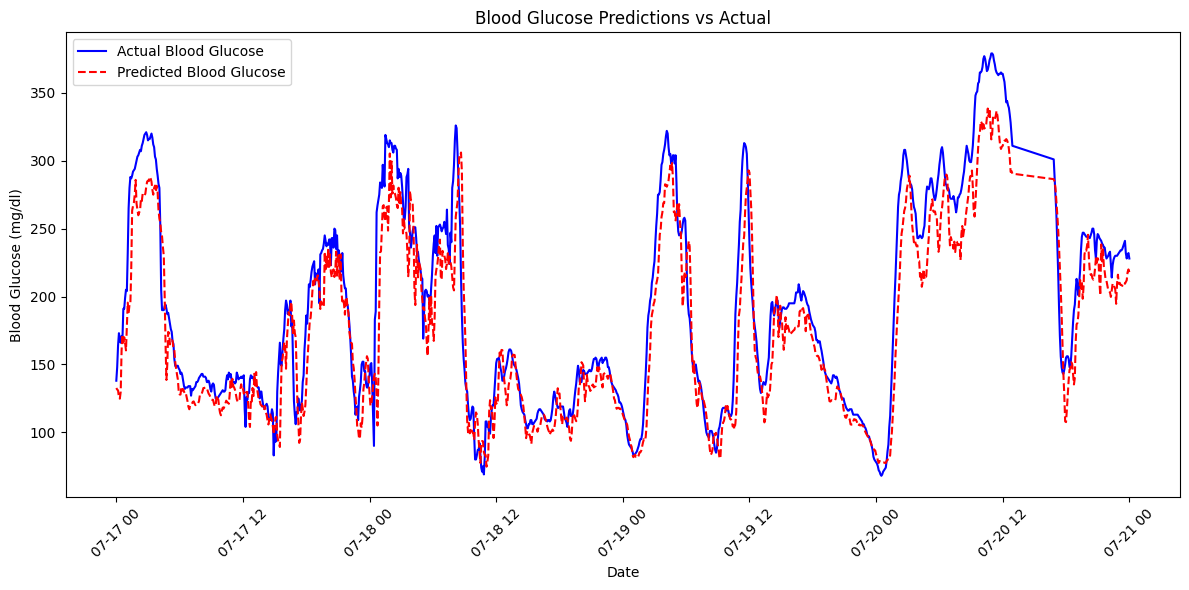

In [42]:
# Plot actual vs predicted for a specific week
def plot_predictions_for_week(data, predictions, actual, start_date, end_date):
    # Filter the test data for the specified week
    week_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].reset_index(drop=True)

    # Get aligned predictions and actual values
    aligned_predictions = predictions[:len(week_data)]
    aligned_actual = actual[:len(week_data)]

    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(week_data['date'], aligned_actual, label='Actual Blood Glucose', color='blue')
    plt.plot(week_data['date'], aligned_predictions, label='Predicted Blood Glucose', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title('Blood Glucose Predictions vs Actual')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot for a specific week
plot_predictions_for_week(merged_data[train_size:], predictions, y_test, '2021-07-17', '2021-07-21')

6

In [43]:
# Create labels for prediction (15 minutes into the future)
forecast_horizon = 6  # 15 minutes (3 readings ahead assuming 5-min intervals)
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to target shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Split into features and labels
features = [f'lag_{i}' for i in range(1, num_lags + 1)] + \
           [f'{var}_lag_{i}' for var in bolus_vars for i in range(1, num_lags + 1)]
X = merged_data[features].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for CNN (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [44]:
# Build CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 134s 15ms/step - loss: 3037.5718 - mae: 39.0496 - val_loss: 1343.5552 - val_mae: 27.5455
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 142s 15ms/step - loss: 1580.3309 - mae: 29.5556 - val_loss: 1323.5687 - val_mae: 27.2463
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 131s 15ms/step - loss: 1539.6511 - mae: 29.1033 - val_loss: 1480.7273 - val_mae: 29.4170
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 138s 16ms/step - loss: 1508.8512 - mae: 28.7968 - val_loss: 1457.1298 - val_mae: 29.2902
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 138s 15ms/step - loss: 1490.9321 - mae: 28.6524 - val_loss: 1387.6954 - val_mae: 28.3378
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 3404.0708 - mae: 32.1495
Test Loss: 10962.509765625, Test MAE: 52.02488327026367
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
Root Mean Squared Error (RMSE): 104.70199144125449


9

In [45]:
# Create labels for prediction (15 minutes into the future)
forecast_horizon = 9  # 15 minutes (3 readings ahead assuming 5-min intervals)
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to target shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Split into features and labels
features = [f'lag_{i}' for i in range(1, num_lags + 1)] + \
           [f'{var}_lag_{i}' for var in bolus_vars for i in range(1, num_lags + 1)]
X = merged_data[features].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for CNN (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [46]:
# Build CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 134s 15ms/step - loss: 3549.7397 - mae: 43.5416 - val_loss: 2069.2803 - val_mae: 35.0482
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 140s 15ms/step - loss: 2114.2649 - mae: 34.6942 - val_loss: 1804.7551 - val_mae: 31.9164
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 147s 15ms/step - loss: 1998.5500 - mae: 33.6842 - val_loss: 1720.5253 - val_mae: 30.6654
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 135s 15ms/step - loss: 1982.9773 - mae: 33.5043 - val_loss: 1552.4979 - val_mae: 28.5984
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 147s 15ms/step - loss: 1965.2493 - mae: 33.2736 - val_loss: 1630.9580 - val_mae: 30.1070
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 5562.3530 - mae: 37.1336
Test Loss: 19833.513671875, Test MAE: 67.63780212402344
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step
Root Mean Squared Error (RMSE): 140.83150506256231


12

In [47]:
# Create labels for prediction (15 minutes into the future)
forecast_horizon = 12  # 15 minutes (3 readings ahead assuming 5-min intervals)
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to target shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Split into features and labels
features = [f'lag_{i}' for i in range(1, num_lags + 1)] + \
           [f'{var}_lag_{i}' for var in bolus_vars for i in range(1, num_lags + 1)]
X = merged_data[features].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for CNN (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [48]:
# Build CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 134s 15ms/step - loss: 3929.1746 - mae: 46.6429 - val_loss: 2623.4177 - val_mae: 39.3462
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 138s 15ms/step - loss: 2584.8518 - mae: 38.8368 - val_loss: 2295.4619 - val_mae: 36.4375
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 144s 15ms/step - loss: 2498.2671 - mae: 38.1111 - val_loss: 2394.2104 - val_mae: 37.3288
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 131s 15ms/step - loss: 2492.4058 - mae: 38.0028 - val_loss: 2292.3103 - val_mae: 36.2430
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 141s 15ms/step - loss: 2444.0586 - mae: 37.6439 - val_loss: 2421.2747 - val_mae: 37.4839
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 6086.5425 - mae: 43.2459
Test Loss: 19657.673828125, Test MAE: 71.13359069824219
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step
Root Mean Squared Error (RMSE): 140.2058478769618


CRNN

In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, TimeDistributed
import matplotlib.pyplot as plt

# Load CGM data
file_path = '/content/drive/My Drive/Thesis/Subject1.xlsx'
cgm_data = pd.read_excel(file_path, sheet_name='CGM')

# Preprocess CGM data - Round to nearest 5 minutes and filter
cgm_data['date'] = pd.to_datetime(cgm_data['date']).dt.round('5min')
cgm_data = cgm_data[cgm_data['mg/dl'] <= 400].dropna(subset=['mg/dl'])
cgm_data = cgm_data.drop_duplicates(subset='date').sort_values(by='date').reset_index(drop=True)

# Generate lag features for CGM data
num_lags = 12  # Using the past 12 readings as features
for lag in range(1, num_lags + 1):
    cgm_data[f'lag_{lag}'] = cgm_data['mg/dl'].shift(lag)

# Load Bolus data
bolus_data = pd.read_excel(file_path, sheet_name='Bolus')
bolus_data['date'] = pd.to_datetime(bolus_data['date']).dt.round('5min')
bolus_data = bolus_data.fillna(0)  # Set missing values to 0

# Merge CGM and Bolus data
merged_data = pd.merge(cgm_data, bolus_data, on='date', how='left').fillna(0)

# Generate lag features for Bolus variables
bolus_vars = ['normal', 'carbInput', 'insulinCarbRatio', 'bgInput',
              'recommended.carb', 'recommended.net', 'recommended.correction',
              'insulinSensitivityFactor', 'targetBloodGlucose', 'insulinOnBoard']

for var in bolus_vars:
    for lag in range(1, num_lags + 1):
        merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)

# Drop rows with NaN due to shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Create labels for prediction (15 minutes into the future)
forecast_horizon = 3  # 15 minutes (3 readings ahead assuming 5-min intervals)
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to target shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Split into features and labels
features = [f'lag_{i}' for i in range(1, num_lags + 1)] + \
           [f'{var}_lag_{i}' for var in bolus_vars for i in range(1, num_lags + 1)]
X = merged_data[features].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for RCNN (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

<ipython-input-49-0af13503f10d>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-49-0af13503f10d>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-49-0af13503f10d>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

In [ ]:
# Build RCNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    LSTM(32, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 394s 44ms/step - loss: 7238.2622 - mae: 66.6681 - val_loss: 5118.1836 - val_mae: 58.7219
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 436s 44ms/step - loss: 5113.5601 - mae: 58.1534 - val_loss: 5024.3823 - val_mae: 58.4150
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 425s 42ms/step - loss: 5055.4990 - mae: 57.8355 - val_loss: 5086.0674 - val_mae: 58.6118
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 348s 39ms/step - loss: 5019.4512 - mae: 57.7148 - val_loss: 5216.9702 - val_mae: 59.0804
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 351s 40ms/step - loss: 4989.7427 - mae: 57.6217 - val_loss: 5176.4604 - val_mae: 58.9294
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - loss: 4413.6782 - mae: 53.8860
Test Loss: 3845.8583984375, Test MAE: 50.54240036010742
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step
Root Mean Squared Error (RMSE): 62.01500030192066


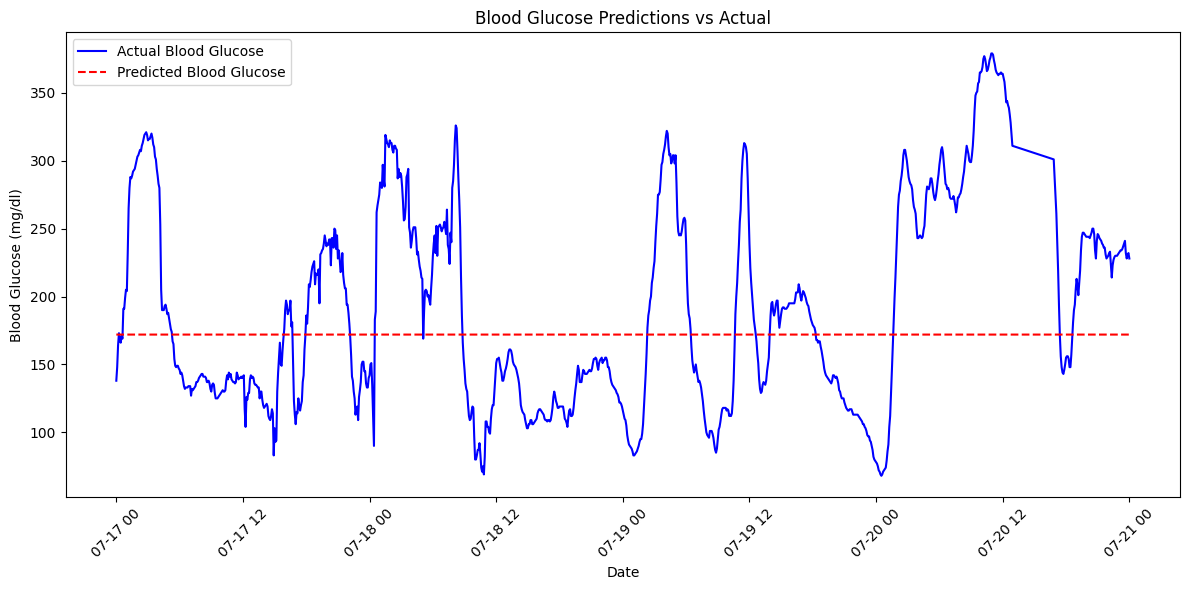

In [ ]:
# Plot actual vs predicted for a specific week
def plot_predictions_for_week(data, predictions, actual, start_date, end_date):
    # Filter the test data for the specified week
    week_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].reset_index(drop=True)

    # Get aligned predictions and actual values
    aligned_predictions = predictions[:len(week_data)]
    aligned_actual = actual[:len(week_data)]

    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(week_data['date'], aligned_actual, label='Actual Blood Glucose', color='blue')
    plt.plot(week_data['date'], aligned_predictions, label='Predicted Blood Glucose', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title('Blood Glucose Predictions vs Actual')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot for a specific week
plot_predictions_for_week(merged_data[train_size:], predictions, y_test, '2021-07-17', '2021-07-21')